In [1]:
import os
import numpy as np
import yaml
from copy import deepcopy
from pathlib import Path
from ultralytics.engine.results import Boxes, Results
import matplotlib.pyplot as plt
from ultralytics.data.utils import check_det_dataset, img2label_paths
from PIL import Image
import numpy as np
import torch
import cv2
from ultralytics import YOLO
from ultralytics.utils.ops import xywh2xyxy, nms_rotated, xyxy2xywh, scale_boxes
from ultralytics.data.augment import LetterBox
import torchvision
from torchvision import transforms as T

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
args = {
    "data": "datasets/v2_malaria_PA3_7_class/data.yaml",
    "model": "trained model/v2 data/v11s_coco_v2data_PA3_7_classes_quadrant_500ep.pt",
    "output": "txt_output/v11s_coco_v2data_PA3_7_classes_quadrant_500ep",
    "overlap_width": 200,
    "overlap_threshold": 10,
    "device": device,
}

In [3]:
def imgnp2tensor(img: np.array, size=None):
    letterbox = LetterBox(new_shape=(640, 640), auto=True)
    img = letterbox(image = img) # chuyển đổi ảnh sang định dạng phù hợp với mô hình
    img = np.ascontiguousarray(img)
    # Chuyển sang RGB, HWC → CHW, rồi sang tensor
    img = img[:, :, ::-1].copy()  # BGR → RGB
    img = img.transpose(2, 0, 1)  # HWC → CHW
    img = torch.from_numpy(img).to(args["device"]).float()  # sang float32
    img /= 255.0
    img = img.unsqueeze(0) # [1, C, H, W]
    return img

# dummy_img = np.zeros((640, 640, 3), dtype=np.uint8)
# dummy_tensor = imgnp2tensor(dummy_img)
# dummy_tensor 

In [4]:
def get_torch_image(args):
    data_dict = check_det_dataset(args["data"])
    img_list_dir = os.listdir(data_dict["test"])
    img_list_dir = [os.path.join(data_dict["test"], x) for x in img_list_dir if x.endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tiff'))]
    output_txt_dir = [os.path.join(args["output"], str(Path(x).with_suffix('.txt').name)) 
                      for x in img_list_dir]

    letterbox = LetterBox(new_shape=(640, 640), auto=True)
    img_list = []
    for img_path in img_list_dir:
        img = cv2.imread(img_path)  # ảnh được đọc dưới dạng BGR, uint8
        img = letterbox(image = img) # chuyển đổi ảnh sang định dạng phù hợp với mô hình
        img = np.ascontiguousarray(img)
        # Chuyển sang RGB, HWC → CHW, rồi sang tensor
        img = img[:, :, ::-1].copy()  # BGR → RGB
        img = img.transpose(2, 0, 1)  # HWC → CHW
        img = torch.from_numpy(img).to(args["device"]).half()  # sang float32
        img /= 255.0
        img = img.unsqueeze(0) # [1, C, H, W]
        img_list.append(img)
    
    return img_list, img_list_dir, output_txt_dir


def get_original_image(args):
    data_dict = check_det_dataset(args["data"])
    img_list_dir = os.listdir(data_dict["test"])
    img_list_dir = [os.path.join(data_dict["test"], x) for x in img_list_dir if x.endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tiff'))]
    output_txt_dir = [os.path.join(args["output"], str(Path(x).with_suffix('.txt').name)) 
                      for x in img_list_dir]
    img_list = []
    for img_path in img_list_dir:
        img = cv2.imread(img_path)
        img_list.append(img)
    
    return img_list, img_list_dir, output_txt_dir
    

In [5]:
img_list, img_list_dir, output_txt_dir = get_original_image(args)


In [6]:
model = YOLO(args["model"]).to(args["device"])
model.half()
next(model.parameters()).dtype

torch.float16

In [7]:
def non_max_suppression(
    prediction,
    conf_thres=0.25,
    iou_thres=0.45,
    classes=None,
    agnostic=False,
    multi_label=False,
    labels=(),
    max_det=300,
    nc=0,  # number of classes (optional)
    max_time_img=0.05,
    max_nms=30000,
    max_wh=7680,
    in_place=True,
    rotated=False,
    end2end=False,
):
    """
    Perform non-maximum suppression (NMS) on a set of boxes, with support for masks and multiple labels per box.

    Args:
        prediction (torch.Tensor): A tensor of shape (batch_size, num_classes + 4 + num_masks, num_boxes)
            containing the predicted boxes, classes, and masks. The tensor should be in the format
            output by a model, such as YOLO.
        conf_thres (float): The confidence threshold below which boxes will be filtered out.
            Valid values are between 0.0 and 1.0.
        iou_thres (float): The IoU threshold below which boxes will be filtered out during NMS.
            Valid values are between 0.0 and 1.0.
        classes (List[int]): A list of class indices to consider. If None, all classes will be considered.
        agnostic (bool): If True, the model is agnostic to the number of classes, and all
            classes will be considered as one.
        multi_label (bool): If True, each box may have multiple labels.
        labels (List[List[Union[int, float, torch.Tensor]]]): A list of lists, where each inner
            list contains the apriori labels for a given image. The list should be in the format
            output by a dataloader, with each label being a tuple of (class_index, x1, y1, x2, y2).
        max_det (int): The maximum number of boxes to keep after NMS.
        nc (int): The number of classes output by the model. Any indices after this will be considered masks.
        max_time_img (float): The maximum time (seconds) for processing one image.
        max_nms (int): The maximum number of boxes into torchvision.ops.nms().
        max_wh (int): The maximum box width and height in pixels.
        in_place (bool): If True, the input prediction tensor will be modified in place.
        rotated (bool): If Oriented Bounding Boxes (OBB) are being passed for NMS.
        end2end (bool): If the model doesn't require NMS.

    Returns:
        (List[torch.Tensor]): A list of length batch_size, where each element is a tensor of
            shape (num_boxes, 6 + num_masks) containing the kept boxes, with columns
            (x1, y1, x2, y2, confidence, class, mask1, mask2, ...).
    """

    # Checks
    assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
    assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"
    if isinstance(prediction, (list, tuple)):  # YOLOv8 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output
    if classes is not None:
        classes = torch.tensor(classes, device=prediction.device)

    if prediction.shape[-1] == 6 or end2end:  # end-to-end model (BNC, i.e. 1,300,6)
        output = [pred[pred[:, 4] > conf_thres][:max_det] for pred in prediction]
        if classes is not None:
            output = [pred[(pred[:, 5:6] == classes).any(1)] for pred in output]
        return output

    bs = prediction.shape[0]  # batch size (BCN, i.e. 1,84,6300)
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4  # number of masks
    mi = 4 + nc  # mask start index
    xc = prediction[:, 4:mi].amax(1) > conf_thres  # candidates

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    time_limit = 2.0 + max_time_img * bs  # seconds to quit after
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)

    prediction = prediction.transpose(-1, -2)  # shape(1,84,6300) to shape(1,6300,84)
    if not rotated:
        if in_place:
            prediction[..., :4] = xywh2xyxy(prediction[..., :4])  # xywh to xyxy
        else:
            prediction = torch.cat((xywh2xyxy(prediction[..., :4]), prediction[..., 4:]), dim=-1)  # xywh to xyxy

    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs # [tensor([], size=(0, 6))] for box, class, score
    output1 = [torch.zeros((0, 4 + nc), device=prediction.device)] * bs # [tensor([], size=(0, 4 + nc))] for box, score1 ,score2, ..., scoreN
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[:, 2:4] < min_wh) | (x[:, 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]) and not rotated:
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 4), device=x.device)
            v[:, :4] = xywh2xyxy(lb[:, 1:5])  # box
            v[range(len(lb)), lb[:, 0].long() + 4] = 1.0  # cls
            x = torch.cat((x, v), 0)
        x1 = x.clone()
        # If none remain process next image
        if not x.shape[0]:
            continue

        # Detections matrix nx6 (xyxy, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1)

        if multi_label:
            i, j = torch.where(cls > conf_thres)
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float(), mask[i]), 1)
            x1 = torch.cat((box[i],               # [N, 4]
                            cls[i],               # [N, nc]
                            ), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            conf_mask = conf.view(-1) > conf_thres
            x = torch.cat((box, conf, j.float(), mask), 1)[conf_mask]
            x1 = torch.cat((box, cls), 1)[conf_mask]  # [box, score1, score2, ..., scoreN]

        # Filter by class
        if classes is not None:
            class_mask = (x[:, 5:6] == classes).any(1)
            x = x[class_mask]
            x1 = x1[class_mask]  # align x1 theo class_mask

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        if n > max_nms:  # excess boxes
            topk = x[:, 4].argsort(descending=True)[:max_nms] # sort by confidence and remove excess boxes
            x = x[topk]
            x1 = x1[topk]  # align x1 theo top confidence  

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        scores = x[:, 4]  # scores
        if rotated:
            boxes = torch.cat((x[:, :2] + c, x[:, 2:4], x[:, -1:]), dim=-1)  # xywhr
            i = nms_rotated(boxes, scores, iou_thres)
        else:
            boxes = x[:, :4] + c  # boxes (offset by class)
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections

        output[xi] = x[i]
        output1[xi] = x1[i]  # align output1 theo i
    return output, output1

In [8]:
def split_image(img, overlap=200):
    """
    Split an image into smaller patches with a specified overlap width.
    """
    h, w = img.shape[:2]
    mid_x, mid_y = w // 2, h // 2
    parts = {
        "Top-left": img[:mid_y + overlap, :mid_x + overlap],
        "Top-right": img[:mid_y + overlap, max(mid_x - overlap, 0):],
        "Bottom-left": img[max(mid_y - overlap, 0):, :mid_x + overlap],
        "Bottom-right": img[max(mid_y - overlap, 0):, max(mid_x - overlap, 0):]
    }
    return parts

def reposition_boxes(boxes: torch.tensor, position, shape, overlap=200):
    h, w = shape
    mid_x, mid_y = w // 2, h // 2
    reshaped_boxes = boxes.clone()
    if position == "Top-left":
        pass
    elif position == "Top-right":
        reshaped_boxes[:, 0] += mid_x - overlap
        reshaped_boxes[:, 2] += mid_x - overlap
    elif position == "Bottom-left":
        reshaped_boxes[:, 1] += mid_y - overlap
        reshaped_boxes[:, 3] += mid_y - overlap
    elif position == "Bottom-right":
        reshaped_boxes[:, 0] += mid_x - overlap
        reshaped_boxes[:, 2] += mid_x - overlap
        reshaped_boxes[:, 1] += mid_y - overlap
        reshaped_boxes[:, 3] += mid_y - overlap
    else:
        raise ValueError(f"Unknown position: {position}. Expected one of 'Top-left', 'Top-right', 'Bottom-left', 'Bottom-right'.")
    
    return reshaped_boxes

def filter_box_in_overlap_area(boxes: torch.tensor, position, shape, overlap=200, threshold=10):
    h, w = shape
    boxes = boxes.clone()  # Make a copy to avoid modifying the original tensor
    mid_x, mid_y = w // 2, h // 2
    if position == "Top-left":
        return boxes[(boxes[:, 2] < mid_x + overlap - threshold) & (boxes[:, 3] < mid_y + overlap - threshold)]
    elif position == "Top-right":
        return boxes[(boxes[:, 0] > mid_x - overlap + threshold) & (boxes[:, 3] < mid_y + overlap - threshold)]
    elif position == "Bottom-left":
        return boxes[(boxes[:, 2] < mid_x + overlap - threshold) & (boxes[:, 1] > mid_y - overlap + threshold)]
    elif position == "Bottom-right":
        return boxes[(boxes[:, 0] > mid_x - overlap + threshold) & (boxes[:, 1] > mid_y - overlap + threshold)]
    else:
        raise ValueError(f"Unknown position: {position}. Expected one of 'Top-left', 'Top-right', 'Bottom-left', 'Bottom-right'.")

    

In [ ]:
def inference(model, data_yaml_dir, img_list, img_list_dir, output_txt_dir):
    results = []
    results1 = [] 
    class_names = check_det_dataset(data_yaml_dir)['names']
    for img_np, img_dir, out_dir in zip(img_list, img_list_dir, output_txt_dir):
        splited_img = split_image(img_np, overlap=args['overlap_width'])
        results_tmp = []
        H, W = img_np.shape[:2]
        for part_name, part_img in splited_img.items():   
            img_torch = imgnp2tensor(part_img) # [1, 3, 640, 640]
            img_torch = img_torch.float() if next(model.parameters()).dtype == torch.float32 else img_torch.half()
            pred = model.model(img_torch)[0] # inference [dbox, cls.sigmoid()], xywhn,
            # print(pred.shape)
            result, result1 = non_max_suppression(pred, 
                                            conf_thres=0.25, 
                                            iou_thres=0.7, 
                                            max_det=300,
                                            nc=len(model.model.names),
                                            agnostic=True,)
            # print(result1[0].shape)

            # img = cv2.imread(img_dir)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            h0, w0 = img_torch.shape[2:]
            h1, w1 = part_img.shape[:2]
    

            result1[0][:, :4] = scale_boxes((h0, w0), result1[0][:, :4], (h1, w1))  # scale boxes to original image size
            
            result1[0] = reposition_boxes(result1[0], 
                                          part_name, 
                                          (H, W), 
                                          overlap=args['overlap_width']) 

            result1[0] = filter_box_in_overlap_area(result1[0], 
                                                    part_name, (H, W), 
                                                    overlap=args['overlap_width'], 
                                                    threshold=args['overlap_threshold']
                                                    ) # filter boxes in overlap area

            # result1[0][:, :4] = scale_boxes((h1, w1), result1[0][:, :4], (H, W))  # scale boxes to original image size

            results_tmp.append(result1[0])  # [N, 4 + nc]
        
        # accumulate results from all parts
        if len(results_tmp) > 0:
            results_tmp = torch.cat(results_tmp, dim=0).unsqueeze(0) # [1, N, 4 + nc]
            results_tmp[..., :4] = xyxy2xywh(results_tmp[..., :4])  # convert xyxy to xywh
            results_tmp = results_tmp.permute(0, 2, 1)  # [1, 4 + nc, N]
            result, result1 = non_max_suppression(results_tmp, 
                                            conf_thres=0.25, 
                                            iou_thres=0.7, 
                                            max_det=300,
                                            nc=len(model.model.names),
                                            agnostic=True)
        else:
            result, result1 = [], []
        
        results.extend(result)
        results1.extend(result1)
        
    
    return results, results1

results, results1 = inference(model, args['data'], img_list, img_list_dir, output_txt_dir)
# results = [box, score, class]
# results1 = [box, score1, score2, ..., scoreN]

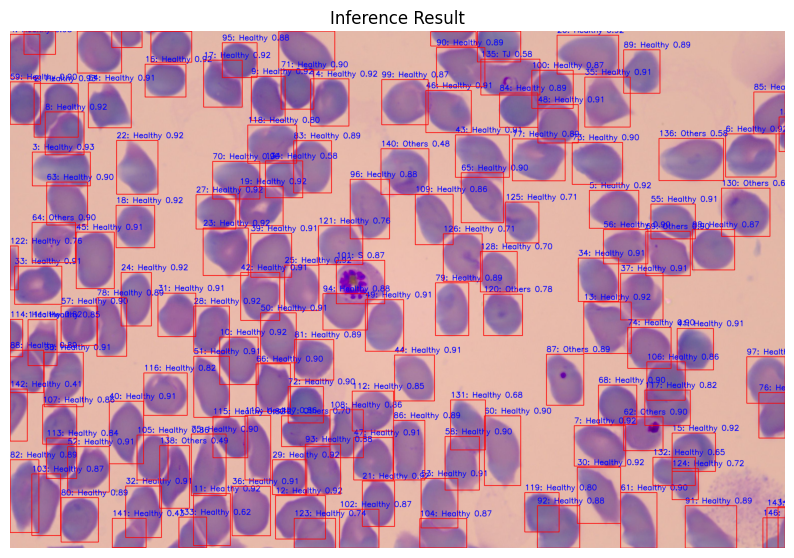

In [11]:
def visulize(results, results1, img_list_dir, img_idx=0):
    result = results[img_idx].clone()  # Clone to avoid modifying original tensor
    result1 = results1[img_idx].clone()
    img_path = img_list_dir[img_idx]
    
    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # letterbox = LetterBox(new_shape=(640, 640), auto=True)
    # processed_img = letterbox(image=img)  # Resize and pad the image
    # h, w = img.shape[:2]
    
    # result[:, :4] = scale_boxes(processed_img.shape[:2], result[:, :4], (h, w))  # scale boxes to original image size
    for i, box in enumerate(result):
        if box.shape[0] == 0:
            continue
        x1, y1, x2, y2, conf, cls = box[:6].cpu().numpy()

        label = f"{i}: {model.model.names[int(cls)]} {conf:.2f}"

        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        cv2.putText(img, label, (int(x1), int(y1) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Show with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Inference Result")
    plt.show()
    
visulize(results, results1, img_list_dir, img_idx=0)
# visulize(results, results1, ['datasets/v2_malaria_PA3_7_class_quadrant/test/images/051Overlay002_0.jpg'], img_idx=0)